<center><img src="https://iispi.com.ar/wp-content/themes/iispi/img/logosfooter-05.png" width="600"><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyQ946reluo38hvW_laUQJasxSZ3hQGVvytmH3KDWHoEEmBKQKw3FNatXU16cHq4a0eCo&usqp=CAU" width="200"> 

<h1 style='text-align: center;'><font size= '5'>Machine Learning e Imágenes en Python (2022)</h1></font> 

# <center> Automatización del conteo de unidades formadoras de colonias bacterianas

<h1 style='text-align: left;'><font size= '4'>· Benelli Federico</h1></font> 
<h1 style='text-align: left;'><font size= '4'>· Rovezzi Juan Pablo</h1></font> 
<h1 style='text-align: center;'><font size= '2'>Dra. Valeria Rulloni - Dra. Ana Carolina Maldonado</h1></font> 

# Introducción
Sobre esta temática hay que responder algunos interrogantes...
- ¿Qué es el conteo de unidades formadoras de colonias bacterianas (UFC/CFU)?
- ¿En qué consiste?
- ¿Cómo podemos mejorar la técnica?

<center><img src="Material/IA_petri.png" width="200"><img src="Material/IA_petriwbacteria.png" width="200">
<center><img src="Material/IA_petrirobot.png" width="200"><img src="Material/IA_robotidea.png" width="200">



<h1 style='text-align: left;'><font size= '6'>Objetivo:</h1></font> 
<h1 style='text-align: left;'><font size= '4'>Diseñar una herramienta de cuantificacion de UFC a partir de fotografias tomadas en plano cenital de capsulas de petri sobre superficies de algun color sólido con el fin de aplicar los conocimientos enseñados y herramientas adquiridas en este curso.</h1></font> 


<center><img src="Material/Petri-A.jpg" width="200"><img src="Material/IA_right.png" width="150"><img src="Material/IA_robotgears.png" width="150"><img src="Material/IA_right.png" width="150"><img src="Material/IA_glass.png" width="150">

# Metodología
<img src="Material/Petri-A.jpg" width="200"><img src="Material/Petri-B.jpg" width="200"><img src="Material/Petri-C.jpg" width="150">
 
<h1 style='text-align: left;'><font size= '4'>Para realizar el conteo de UFCs de una manera automatizada se utilizó un enfoque de entrenamiento semi- supervisado, utilizando un modelo K-Nearest Neighbors (KNN). La implementación fue realizada en Python, con soporte de las librerías opencv, matplotlib, pandas, numpy y sklearn.
Para llevarlo a cabo se requirieron 3 etapas:</h1></font> 

- Carga de imagen y preprocesamiento
- Entrenamiento de modelo y categorización de datos
- Conteo de UFCs


<center><img src="Material/IA_robotfunny.png" width="200"> 

## Librerias

In [1]:
# Numpy para calculo vectorial
import numpy as np
import math
# cv2 para trabajar con imagenes
import cv2

# matplotlib para graficar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

# Pandas para manipular datos
import pandas as pd

# sklearn para machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, decomposition
# 
from IPython.display import clear_output 
from collections import Counter
from ipywidgets import interact, widgets

# Nuestra propia libreria de funciones
from Modulos.funciones import *

# Parametros por defecto de matplotlib
plt.rcParams['figure.figsize'] = [5, 5]

## Funciones

In [2]:
def gen_df(image):
    """
    Generar df de una imagen BGR o Grayscale
    """
    
    shape = image.shape
    if len(shape) == 3:
      ny, nx, _ = shape
      ncols = 5
    elif len(shape) == 2:
      ny, nx = shape
      ncols = 3

    npix = ny*nx
    data = np.zeros([npix, ncols], dtype="int")
    ind = np.indices((ny, nx))

    data[:, 0] = ind[0].flatten() #filas
    data[:, 1] = ind[1].flatten() #columnas

    data[:, 2] = image[:, :, 0].flatten() #rojo
    data[:, 3] = image[:, :, 1].flatten() # verde
    data[:, 4] = image[:, :, 2].flatten() # azul

    df = pd.DataFrame(data, columns=["fila", "columna", "b", "g", "r"])
    
    return df

def crop_limits(img):
  """Recibe una imagen, espera a la seleccion de los puntos de interes
  y extrae la capsula de petri
  """
  def click_event(event, x, y, flags, params):
     if event == cv2.EVENT_LBUTTONDOWN:
        print(f'({x},{y})')

        # put coordinates as text on the image
        cv2.putText(img_copy, f'({x},{y})',(x,y),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # draw point on the image
        cv2.circle(img_copy, (x,y), 3, (0,255,255), -1)

        COORDS.append((x,y))
  
  COORDS = []

  # Copy the image to show and don't modify the original one
  img_copy = img.copy()

  # create a window
  cv2.namedWindow('Point Coordinates')

  # bind the callback function to window
  cv2.setMouseCallback('Point Coordinates', click_event)

  # display the image
  coords = []
  while True:
     cv2.imshow('Point Coordinates', img)
     k = cv2.waitKey(1) & 0xFF
     if len(COORDS) == 2:
      break

def mkcircle(image):
  """Borrar imagen fuera del circulo.

  Toma una imagen de un rectángulo y, asumiendo
  que los bordes de la imagen son tangentes al
  círculo, vuelve totalmente blancas las zonas
  externas al círculo.

  image: imagen cv2 (numpy array de tres dimensiones)
    Imagen a recortar
  """
  height = image.shape[0]
  width = image.shape[1]
  y_offset = 0
  x_offset = 0
  offset = -30
  for y in range(height):
    for x in range(width):
      if (
          (x - width/2 +x_offset) * (x - width/2 +x_offset) 
          + (y - height/2 +y_offset) * (y-height/2 +y_offset) 
          >= (height/2 + offset) * (height/2 +offset)
          ):
        
        image[y, x, 0] = 0
        image[y, x, 1] = 0
        image[y, x, 2] = 0
  return image

def mkcircle_petri(offset,background):
  """Borrar imagen fuera del circulo.

  Toma una imagen de un rectángulo y, asumiendo
  que los bordes de la imagen son tangentes al
  círculo, vuelve totalmente blancas las zonas
  externas al círculo.

  image: imagen cv2 (numpy array de tres dimensiones)
    Imagen a recortar
  """
  #image = petri
  #global petri
  height = petri.shape[0]
  width = petri.shape[1]
  for y in range(height):
    for x in range(width):
      if (
          (x - width/2) * (x - width/2) 
          + (y - height/2) * (y-height/2) 
          >= (height/2 - offset/10) * (height/2 -offset/10)
          ):
        
        petri[y, x, 0] = background
        petri[y, x, 1] = background
        petri[y, x, 2] = background
  plt.imshow(petri)
  
  #return petri
  return None

def blob_finder(image):
  """
  Esta funcion no se usa, la deje por las dudas. Se supone que puede
  identificar figuras genericas aisladas
  """
  # Set our filtering parameters
  # Initialize parameter setting using cv2.SimpleBlobDetector
  params = cv2.SimpleBlobDetector_Params()
  
  # Set Area filtering parameters
  params.filterByArea = False
  params.minArea = 10
  
  # Set Circularity filtering parameters
  params.filterByCircularity = True
  params.minCircularity = 0.9
  
  # Set Convexity filtering parameters
  params.filterByConvexity = False
  params.minConvexity = 0.2
  
  # Set inertia filtering parameters
  params.filterByInertia = True
  params.minInertiaRatio = 0.8
  
  # Create a detector with the parameters
  detector = cv2.SimpleBlobDetector_create(params)
  
  # Detect blobs
  keypoints = detector.detect(
    np.array(image, dtype="uint8")
  )
  
  # Draw blobs on our image as red circles
  blank = np.zeros((1, 1))
  blobs = cv2.drawKeypoints(
    image, keypoints, blank, (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
  )

  return blobs

def get_area(image, msg):
  r = cv2.selectROI(msg, image)

  # Crop image
  img = image[
      int(r[1]):int(r[1]+r[3]),
      int(r[0]):int(r[0]+r[2])
  ]

  return img, r

def set_threshold(thresh_min, thresh_max):
  global thresh_min_out 
  global thresh_max_out
  #global desired_colony 
  # Binarizar colonia deseada y entrenar kmeans
  desired_gray = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2GRAY)
  desired_bin = (
      (desired_gray > thresh_min) & (desired_gray < thresh_max)
  ) * 1
  thresh_min_out = thresh_min
  thresh_max_out  = thresh_max
  plt.imshow(desired_bin)
  plt.colorbar()
  plt.imshow(desired_colony, alpha=0.7)
  return thresh_min, thresh_max

# Carga de imágen a analizar y preprocesamiento
<center> <img src="Material/IA_robotbox.png" width="200">

<h1 style='text-align: left;'><font size= '4'>Partiendo de una imagen, se selecciona un área que representa específicamente a la cápsula de petri, una vez seleccionada se extrae además una subárea correspondiente a una serie de colonias que se desea contabilizar. Posteriormente se realiza un recorte del área exterior a la cápsula, con el fin de facilitar la categorización posterior al tener una imagen más limpia.</h1></font> 

<center> <img src="Material/figura1.jpg" width="200">
<center> <img src="Material/figura2.jpg" width="500">


In [66]:
input_path = "Ejemplo/input.jpg"
image = cv2.imread(input_path)

print("Resolucion inicial:",image.shape)

if image.shape >= (400,400,3):
    # Reducir el tamaño de imagen para agilizar el proceso
    image = cv2.resize(image,(400,400)) 

print("Resolucion resultante:",image.shape)

print("La imagen es almacenada como:", type(image))
print("Y los datos cargados dentro son:", type(image[0,0,0]))

Resolucion inicial: (1024, 1024, 3)
Resolucion resultante: (400, 400, 3)
La imagen es almacenada como: <class 'numpy.ndarray'>
Y los datos cargados dentro son: <class 'numpy.uint8'>


In [14]:
# Selección de cápsula de petri
petri, petri_range = get_area(image, "Select Petri")
cv2.destroyWindow('Select Petri')

# Selección de colonia para etiquetar
desired_colony, colony_range = get_area(image, "Select Colony")
cv2.destroyWindow('Select Colony')

ny, nx, _ = petri.shape

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


In [15]:
# Guardado de imagenes en otra parte, para tener acceso ante cualquier
# eventualidad
cv2.imwrite("tmp_petri.jpg", petri)
cv2.imwrite("tmp_desired_colony.jpg", desired_colony)

True

In [16]:
# Conversión de imagen BGR a RGB
petri = cv2.cvtColor(petri, cv2.COLOR_BGR2RGB)
desired_colony = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2RGB)
gray_petri = cv2.cvtColor(petri, cv2.COLOR_BGR2GRAY)

# Generación de DataFrames con las imágenes
df_petri = gen_df(petri)
df_desired = gen_df(desired_colony)

In [17]:
#Recortar exterior
interact(
    mkcircle_petri,
    offset=widgets.IntSlider(
        min=-petri.shape[0]*1.1,
        max=petri.shape[0]*1.1,
        step=1,
        value=-petri.shape[0]*10,
        layout=widgets.Layout(width='500px')
    ),
    background=widgets.IntSlider(
        min=0, 
        max=255,
        step=255, value=0,layout=widgets.Layout(width='200px')),
    dish = petri,
)

interactive(children=(IntSlider(value=-436, description='offset', layout=Layout(width='500px'), max=436, min=-…

<function __main__.mkcircle_petri(offset, background)>

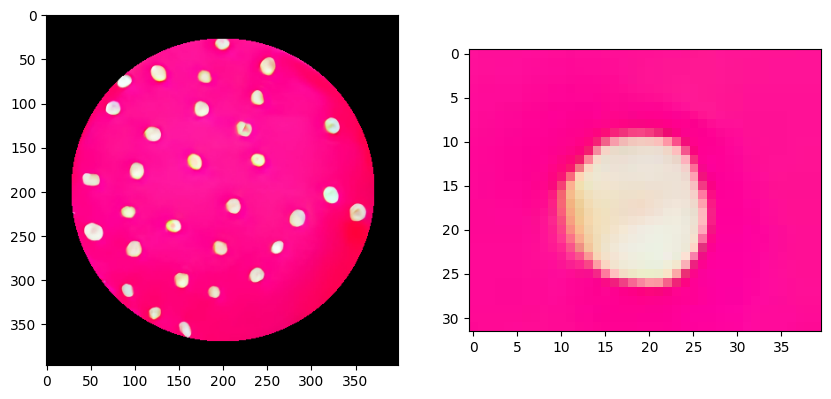

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(petri)
ax[1].imshow(desired_colony)

# Entrenamiento de modelo y categorización de datos
<h1 style='text-align: left;'><font size= '6'>¿Cómo continuar?</h1></font> 

- ### Binarización, establecimiento de un umbral y etiquetado de colonia de interés
<center> <img src="Material/umbral1.jpg" width="212"><img src="Material/umbral2.jpg" width="200"><img src="Material/binarizado.jpg" width="265">
<center> <img src="Material/IA_robotbw.png" width="150">>

In [51]:
# Obtención 
interact(
    set_threshold,
    thresh_min=widgets.IntSlider(min=0, max=255, step=1, value=0),
    thresh_max=widgets.IntSlider(min=0, max=255, step=1, value=0)
)



interactive(children=(IntSlider(value=0, description='thresh_min', max=255), IntSlider(value=0, description='t…

<function __main__.set_threshold(thresh_min, thresh_max)>

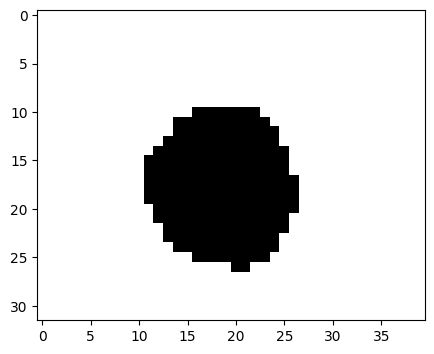

In [59]:
# Binarizar colonia deseada con los valores preestablecidos
desired_gray = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2GRAY)
desired_bin = ((thresh_min_out < desired_gray) & (desired_gray < thresh_max_out)) * 1
plt.imshow(desired_bin)

In [60]:
#Generacion del Datafram
df_desired["label"] = desired_bin.flatten()
df_desired

,fila,columna,b,g,r,label
0,0,0,255,17,154,0
1,0,1,254,15,153,0
2,0,2,254,15,153,0
3,0,3,254,15,153,0
4,0,4,254,15,153,0
...,...,...,...,...,...,...
1275,31,35,255,11,155,0
1276,31,36,254,10,153,0
1277,31,37,254,10,150,0
1278,31,38,254,10,149,0


## Entrenamiento KNN
Una vez definido el DataFrame con los datos catalogados se procede a entrenar un
modelo clasificador para detectar la colonia deseada. Como modelo se eligió
K-Nearest Neighbours (KNN), debido a que las colonias se tratan de datos 
agrupados por regiones.
<center><img src="Material/IA_robottreadmill.png" width="150">

In [61]:
knn = KNeighborsClassifier(n_neighbors=20, weights="distance")
knn.fit(df_desired.iloc[:, 2:-1], df_desired["label"])

KNeighborsClassifier(n_neighbors=20, weights='distance')

## Predicción en todo el set de datos
Una vez teniendo el modelo entrenado se realiza la predicción en toda la imagen.
<center> <img src="Material/IA_robotcrystal.png" width="200">

Cluster:  0


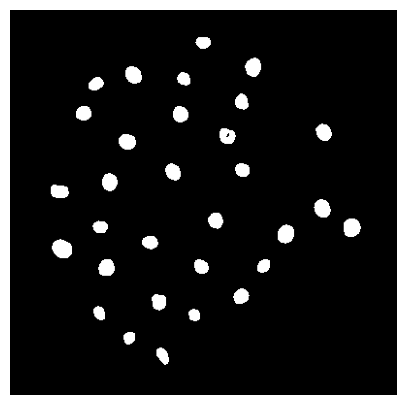

Cluster:  1


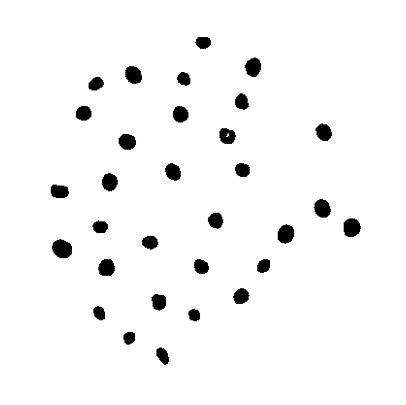

In [62]:
# Generacion del dataframe de la imagen original (recortada)
df_petri = gen_df(petri)

# Prediccion con KMeans entrenada
labels = knn.predict(df_petri.iloc[:, 2:])
df_petri["labels"] = labels

for label in df_petri["labels"].unique():
    print("Cluster: ", label)
    colonies = (df_petri["labels"].values.reshape((ny, nx)) == label) * 1
    plt.imshow(colonies)
    plt.axis('off')
    plt.set_cmap(cmap="binary")
    plt.savefig("Colonies"+str(label)+".png", bbox_inches='tight')
    plt.axis('off')
    plt.show()

# Conteo de número de UFCs

Para el conteo de UFCs se implementaron dos métodos:

- Relaciones de áreas
- Conteo de 
### Relaciones de áreas

Sabiendo el número de colonias en el recorte realizado se calcula el área
promedio que corresponde a una colonia. El área se mide en unidades de pixeles
y el área promedio se determina según:

$\frac{N_{pixeles totales}}{N_{colonias}}$

### Conteo de puntos
Como método alternativo se utilizó un algoritmo contador de componentes (cv2.connectedComponents) utilizando la imagen de las colonias ya catalogadas mediante KNN.

<center> <img src="Material/IA_robot_calc.png" width="200">

In [63]:
# Cantidad de colonias en el recorte de clasificación
n_desired = 1

# Determinación de area promedio
area = len(df_desired[df_desired["label"] == label])
mean_area = area/n_desired

if mean_area <= 0:
    raise Exception("Ajustar la Binarización de la Colonia")

# Determinación de número de colonias
n_colonies = len(df_petri[df_petri["labels"] == label])/mean_area


In [64]:
# Codigo de conteo de areas cerradas

# Creacion de un matriz vacía para analizar conteos
ResultingList = [0]*2

# Analisis de cada una de las imagenes creadas
for i in list(range(2)):
    img = cv2.imread("Colonies"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
    countx = 0
    county = 0
  
    # Verificacion si se tiene un recuadro blanco y si se debe pintar de negro:
    for k in list(range(0,img.shape[1]-1)):
        if (img[int(img.shape[0]/2),k] == 255):
            countx+=1
        else: break
    for j in list(range(0,img.shape[0]-1)):
        if (img[j,int(img.shape[1]/2)] == 255):
            county+=1
        else: break

    if countx <=10:
        for m in list(range(0,img.shape[0]-1)):
            img[m,:10] = 0
            img[m,-10:] = 0
        for n in list(range(0,img.shape[1]-1)):
            img[:10,n] = 0
            img[-10:,n] = 0

    # Inversion de colores (blanco a negro y negro a blanco):
    for r in list(range(0,img.shape[1]-1)):
        for s in list(range(0,img.shape[0]-1)):
            if (img[s,r] == 255):
                img[s,r] = 0
            else:
                img[s,r] = 255

   
    # Creacion de un rectangulo de 3x3 como kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Aplicacion  de un umbral con los limites establecidos antes
    mask = cv2.threshold(img, thresh_min_out, thresh_max_out, cv2.THRESH_BINARY)[1]


    # Eliminacion de ruido de la imagen
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Relleno de las areas cerradas
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    #Recuento de todas las areas cerradas que se encuentran en la imagen
    n_centers = cv2.connectedComponents(mask)[0] - 1
    #print(n_centers)
    ResultingList[i] = n_centers 

# Ordenamiento del conteo de menor a mayor 
ResultingList = sorted(ResultingList)


# Resultados
<center> <img src="Material/IA_robot31.png" width="150"> 

In [65]:
# Impresion por pantalla de los resultados finales.
print("RESULTADOS FINALES:")
print(
f"# Segun un calculo basado en superficies,\
 hay {math.ceil(n_colonies)} colonia(s)."
 )
print(
f"# Mientras que, por un conteo por bordes y areas cerradas,\
 hay {ResultingList[1]} colonia(s)."
)



RESULTADOS FINALES:
# Segun un calculo basado en superficies, hay 31 colonia(s).
# Mientras que, por un conteo por bordes y areas cerradas, hay 31 colonia(s).


# Conclusiones
- Se implementó un modelo KNN capaz de identificar y contabilizar UFC de manera eficiente y en gran medida automatizada. 
- Se podría realizar el conteo de múltiples colonias distintas dentro de la misma cápsula. 
- Sería necesario realizar mejoras en la técnica de categorización (eliminación de flash, ruido y brillos en la imagen)

<h1 style='text-align: center;'><font size= '10'>¡MUCHAS GRACIAS!</h1></font>
<center> <img src="Material/IA_robotfamily.png" width="150"> 
